In [1]:
!pip install thop
!pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter


In [3]:
# Create SummaryWriter
writer = SummaryWriter("../tensorboard")

In [4]:
#檢查是否可用gpu
print(torch.cuda.is_available())

True


In [5]:
# 計算normalization需要的mean & std
def get_mean_std(dataset, ratio=0.3):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

100%|██████████| 170498071/170498071 [00:03<00:00, 43011516.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[0.49192137 0.48259753 0.44635892] [0.24729666 0.24388425 0.26217312]
[0.49192137 0.48259753 0.44635892] [0.24729666 0.24388425 0.26217312]


In [6]:
##### data augmentation & normalization #####
transform_train = transforms.Compose([
    transforms.ToTensor(),

    # data augmentation
    transforms.RandomHorizontalFlip(),  # 隨機水平翻轉
    transforms.RandomCrop(32, padding=4),  # 隨機裁剪
    transforms.RandomRotation(15),  # 隨機旋轉
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 隨機亮度、對比度等

    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(mean=train_mean, std=train_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(mean=train_mean, std=train_std),
])

In [7]:
# dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 檢查training dataset
#print("trainset length: ", len(trainset))
#print("classes: ", trainset.classes)
image, label = trainset[0]
print("image shape: ", image.shape)
#print("label: ", label)

# Cifar-10的標籤: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# split validation dataset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
val_size = 5000       # 取5000張驗證集(0.1 of trainset)
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

# 宣告 batch size
BATCH_SIZE = 64
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
image shape:  torch.Size([3, 32, 32])
train length:  45000
val length:  5000
test length:  10000


# Task 1
1. 搭建由{CNN,BN,ReLU}所組成的layer
2. 用兩層layer搭配pooling layer 和 FC layer創建出model
3. 進行訓練並分別繪製出train acc/train loss/val acc/ val loss 等圖

In [16]:
import torch.nn.functional as F

#####   create your own model  #####
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 第一層卷積層，輸入 3 通道（RGB），輸出 32 個通道
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        # 第二層卷積層，輸入 16 通道，輸出 64 個通道
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # 第二層卷積層，輸入 16 通道，輸出 64 個通道
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        # 池化層
        self.pool = nn.MaxPool2d(2, 2)

        # 加入 Dropout 層，丟棄 25% 的神經元
        #self.dropout = nn.Dropout(0.25)

        # 全連接層，輸入 32*8*8，輸出 10（CIFAR-10 類別數）
        self.fc = nn.Linear(128 * 4 * 4, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(-1, 128 * 4 * 4)  # 展平成一維向量
        #x = self.dropout(x)
        x = self.fc(x)
        return x

# 宣告model
task1_model = SimpleCNN().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [17]:
from thop import profile
from torchsummary import summary


##### 使用 thop 計算 FLOPs 和參數數量 #####
# 假設 CIFAR-10 圖片大小為 (3, 32, 32)
# 創建一個隨機輸入張量
input = torch.randn(1, 3, 32, 32).to(task1_model.fc.weight.device)
flops, params = profile(task1_model, inputs=(input, ))
print(f"FLOPs: {flops}")
print(f"Params: {params}")

summary(task1_model, (3, 32, 32))


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 10571776.0
Params: 114186.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 

In [18]:
##### setting parameter #####
task1_EPOCH = 30
task1_pre_epoch = 0
task1_lr = 0.001
task1_device = torch.device("cuda")

In [19]:
##### Train model #####

# 初始化模型損失函數與優化器
task1_criterion = nn.CrossEntropyLoss()
#task1_scheduler = optim.lr_scheduler.ReduceLROnPlateau(task1_optimizer, mode='min', factor=0.5, patience=5)
task1_optimizer = optim.Adam(task1_model.parameters(), lr=task1_lr, betas=(0.9, 0.98))  # 使用 Adam 優化器
#task1_optimizer = optim.SGD(task1_model.parameters(), lr=task1_lr, momentum=0.9, nesterov=True)

task1_scheduler = optim.lr_scheduler.StepLR(task1_optimizer, step_size=10, gamma=0.5)  # 學習率調整策略

# 設定參數
task1_best_model_path = 'task1_best_model.pth'  # 模型保存路徑

# 用於記錄 loss 和 accuracy 的列表
task1_train_losses = []
task1_train_accuracies = []

task1_val_losses = []
task1_val_accuracies = []

##### Train model #####
task1_best_acc = 0.0  # 用來追蹤最佳驗證準確率

# 訓練模型
for epoch in range(task1_pre_epoch, task1_EPOCH):
    task1_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(task1_device), labels.to(task1_device)

        # 初始化梯度
        task1_optimizer.zero_grad()

        # 前向傳播
        outputs = task1_model(inputs)
        loss = task1_criterion(outputs, labels)

        # 反向傳播與優化
        loss.backward()
        task1_optimizer.step()

        # 累積損失
        running_loss += loss.item()

        # 計算訓練準確率
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    task1_train_loss = running_loss / len(trainloader)
    task1_train_accuracy = 100. * correct / total
    task1_train_losses.append(task1_train_loss)
    task1_train_accuracies.append(task1_train_accuracy)

    # 驗證模型
    task1_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(task1_device), labels.to(task1_device)

            outputs = task1_model(inputs)
            loss = task1_criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    task1_val_loss = val_loss / len(valloader)
    task1_val_accuracy = 100. * correct / total
    task1_val_losses.append(task1_val_loss)
    task1_val_accuracies.append(task1_val_accuracy)

    # 保存最佳模型
    if task1_val_accuracy > task1_best_acc:
        task1_best_acc = task1_val_accuracy
        torch.save(task1_model.state_dict(), task1_best_model_path)

    # 調整學習率
    task1_scheduler.step()

    print(f"Epoch [{epoch+1}/{task1_EPOCH}] - Train Loss: {task1_train_loss:.4f}, Train Acc: {task1_train_accuracy:.2f}%, Val Loss: {task1_val_loss:.4f}, Val Acc: {task1_val_accuracy:.2f}%")

print('Finished Task 1 Training')

# load 你的best model再跑一次testloader
# 加載最佳模型
task1_model.load_state_dict(torch.load(task1_best_model_path, weights_only=True))
task1_model.eval()

# 在測試集上評估
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(task1_device), labels.to(task1_device)
        outputs = task1_model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

task1_test_accuracy = 100. * correct / total
print(f"Task 1 Test Accuracy: {task1_test_accuracy:.2f}%")

Epoch [1/30] - Train Loss: 1.4881, Train Acc: 46.45%, Val Loss: 1.3212, Val Acc: 51.76%
Epoch [2/30] - Train Loss: 1.1611, Train Acc: 58.84%, Val Loss: 1.0693, Val Acc: 62.78%
Epoch [3/30] - Train Loss: 1.0450, Train Acc: 63.03%, Val Loss: 1.1380, Val Acc: 60.50%
Epoch [4/30] - Train Loss: 0.9645, Train Acc: 66.08%, Val Loss: 1.0286, Val Acc: 63.68%
Epoch [5/30] - Train Loss: 0.9077, Train Acc: 68.18%, Val Loss: 0.9645, Val Acc: 66.60%
Epoch [6/30] - Train Loss: 0.8625, Train Acc: 69.69%, Val Loss: 0.8662, Val Acc: 69.46%
Epoch [7/30] - Train Loss: 0.8349, Train Acc: 71.12%, Val Loss: 0.8731, Val Acc: 69.66%
Epoch [8/30] - Train Loss: 0.7930, Train Acc: 72.18%, Val Loss: 0.8276, Val Acc: 71.26%
Epoch [9/30] - Train Loss: 0.7678, Train Acc: 73.14%, Val Loss: 0.8004, Val Acc: 72.14%
Epoch [10/30] - Train Loss: 0.7478, Train Acc: 73.77%, Val Loss: 0.7755, Val Acc: 72.82%
Epoch [11/30] - Train Loss: 0.6843, Train Acc: 76.29%, Val Loss: 0.7296, Val Acc: 74.32%
Epoch [12/30] - Train Loss: 0.

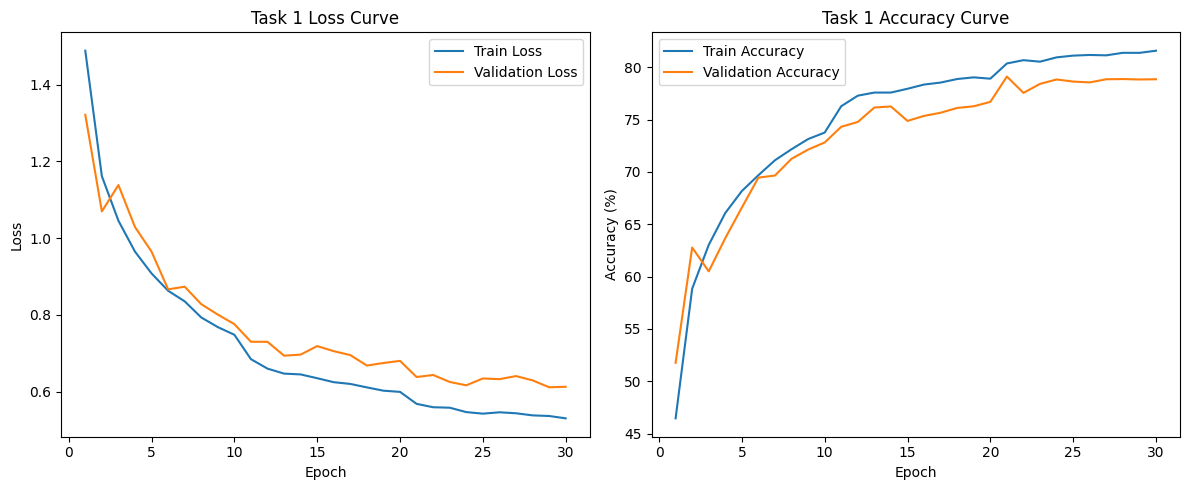

In [20]:
import matplotlib.pyplot as plt

##### 繪製 loss 和 accuracy 的圖 #####
plt.figure(figsize=(12, 5))

# 繪製 Loss 圖
plt.subplot(1, 2, 1)
plt.plot(range(1, task1_EPOCH + 1), task1_train_losses, label='Train Loss')
plt.plot(range(1, task1_EPOCH + 1), task1_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Task 1 Loss Curve')
plt.legend()

# 繪製 Accuracy 圖
plt.subplot(1, 2, 2)
plt.plot(range(1, task1_EPOCH + 1), task1_train_accuracies, label='Train Accuracy')
plt.plot(range(1, task1_EPOCH + 1), task1_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Task 1 Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Task 2
1. 完成resnet18.py並上傳
2. 進行訓練並分別繪製出train acc/train loss/val acc/ val loss 等圖

In [22]:
from thop import profile
from resnet18 import *
##### 使用 thop 計算 FLOPs 和 參數數量 #####

In [23]:
# setting parameter
task2_EPOCH = 20
task2_pre_epoch = 0
task2_lr = 0.001
task2_device = torch.device("cuda")

In [24]:
# 引用 resnet18
task2_net = ResNet(ResBlock, [2, 2, 2, 2], num_classes=10).to(task2_device)

# 計算 FLOPs 和參數數量
flops, params = profile(task2_net, inputs=(torch.randn(1, 3, 32, 32).to(task2_device),))
print(f"Task 2 FLOPs: {flops / 1e9:.2f}G, Params: {params / 1e6:.2f}M")

# 定義損失函數和優化器
task2_criterion = nn.CrossEntropyLoss()
task2_optimizer = torch.optim.Adam(task2_net.parameters(), lr=0.001, weight_decay=1e-4)


# 儲存訓練過程中的損失與準確率
task2_train_losses = []
task2_train_accuracies = []
task2_val_losses = []
task2_val_accuracies = []

# 保存最佳模型的文件路徑
task2_best_model_path = 'task2_best_model.pth'
task2_best_acc = 0.0  # 用來追蹤最佳驗證準確率

# 訓練模型
for epoch in range(task2_EPOCH):
    task2_net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(task2_device), targets.to(task2_device)

        # 前向傳播
        outputs = task2_net(inputs)
        loss = task2_criterion(outputs, targets)

        # 反向傳播與優化
        task2_optimizer.zero_grad()
        loss.backward()
        task2_optimizer.step()

        # 計算訓練損失與準確率
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    task2_train_losses.append(train_loss / len(trainloader))
    task2_train_accuracies.append(100. * correct / total)

    # 驗證模型
    task2_net.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(task2_device), targets.to(task2_device)
            outputs = task2_net(inputs)
            loss = task2_criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    task2_val_losses.append(val_loss / len(valloader))
    task2_val_accuracies.append(100. * correct / total)

    # 保存最佳模型
    if task2_val_accuracies[-1] > task2_best_acc:
        task2_best_acc = task2_val_accuracies[-1]
        torch.save(task2_net.state_dict(), task2_best_model_path)

    print(f"Epoch {epoch+1}/{task2_EPOCH} | Train Loss: {task2_train_losses[-1]:.3f} | Train Acc: {task2_train_accuracies[-1]:.3f}% | Val Loss: {task2_val_losses[-1]:.3f} | Val Acc: {task2_val_accuracies[-1]:.3f}%")

print('Finished Task 2 Training')

# 加載最佳模型
task2_net.load_state_dict(torch.load(task2_best_model_path))
task2_net.eval()



[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Task 2 FLOPs: 0.56G, Params: 11.17M
Epoch 1/20 | Train Loss: 1.569 | Train Acc: 42.393% | Val Loss: 1.319 | Val Acc: 51.360%
Epoch 2/20 | Train Loss: 1.169 | Train Acc: 58.113% | Val Loss: 1.190 | Val Acc: 58.540%
Epoch 3/20 | Train Loss: 0.992 | Train Acc: 65.040% | Val Loss: 1.280 | Val Acc: 58.480%
Epoch 4/20 | Train Loss: 0.860 | Train Acc: 69.876% | Val Loss: 0.850 | Val Acc: 70.220%
Epoch 5/20 | Train Loss: 0.759 | Train Acc: 73.622% | Val Loss: 0.826 | Val Acc: 70.980%
Epoch 6/20 | Train Loss: 

<ipython-input-24-3db7902bc661>:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  task2_net.load_state_dict(torch.load(task2_best_model_path))


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)

In [25]:
# 測試集上評估
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(task2_device), labels.to(task2_device)
        outputs = task2_net(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

task2_test_accuracy = 100. * correct / total
print(f"Task 2 Test Accuracy: {task2_test_accuracy:.2f}%")

Task 2 Test Accuracy: 86.69%


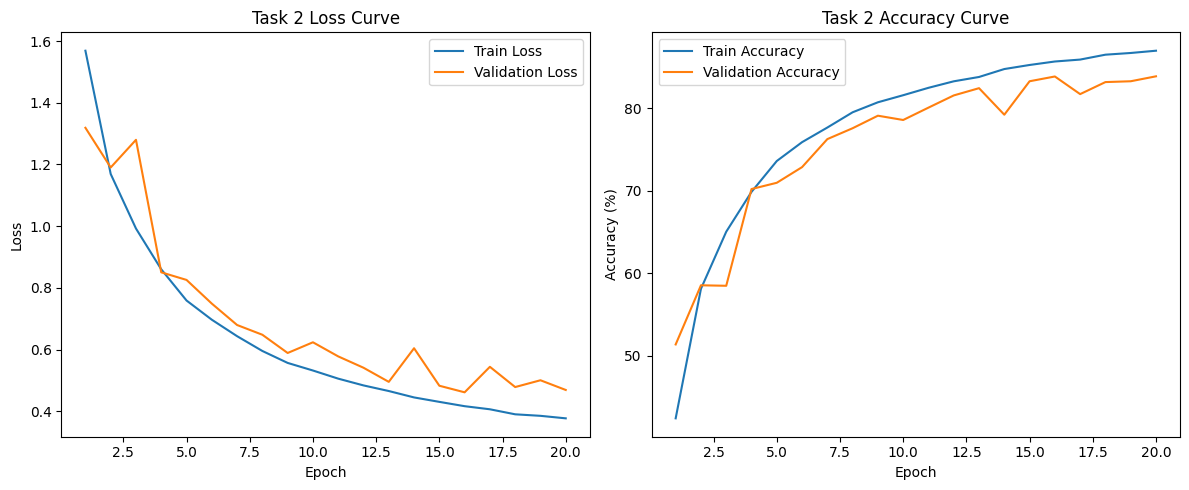

In [26]:
##### 繪製 loss 和 accuracy 的圖 #####
plt.figure(figsize=(12, 5))

# 繪製 Loss 圖
plt.subplot(1, 2, 1)
plt.plot(range(1, task2_EPOCH + 1), task2_train_losses, label='Train Loss')
plt.plot(range(1, task2_EPOCH + 1), task2_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Task 2 Loss Curve')
plt.legend()

# 繪製 Accuracy 圖
plt.subplot(1, 2, 2)
plt.plot(range(1, task2_EPOCH + 1), task2_train_accuracies, label='Train Accuracy')
plt.plot(range(1, task2_EPOCH + 1), task2_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Task 2 Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()